In [1]:
import numba
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader

sns.set(font_scale=1.4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Следующая функция - явная схема для уравнения теплопроводности, один шаг по времени.

In [0]:
def get_next_step(theta, h, tau):
    """
    theta --- (N + 1, N + 1) array
    h --- space step
    tau --- time step
    """

    N = len(theta) - 1
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], 
                                N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], 
                            N-1, axis=0)
    
    vicinity = theta[x_index + 1, y_index] + theta[x_index, y_index + 1] + \
               theta[x_index - 1, y_index] + theta[x_index, y_index -1]
    
    right_side = (vicinity - 4 * theta[x_index, y_index]) * tau / h ** 2
    theta[x_index, y_index] += right_side

    residual = np.linalg.norm(right_side[:]/tau) * h**0.5

    return theta, residual

def compute_residual(theta, h, tau):
    """
    theta --- (N + 1, N + 1) array
    h --- space step
    tau --- time step
    """

    N = len(theta) - 1
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], 
                                N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], 
                            N-1, axis=0)
    
    vicinity = theta[x_index + 1, y_index] + theta[x_index, y_index + 1] + \
               theta[x_index - 1, y_index] + theta[x_index, y_index -1]
    
    right_side = (vicinity - 4 * theta[x_index, y_index]) * tau / h ** 2

    residual = np.linalg.norm(right_side[:]/tau) * h**0.5

    return  residual

Задаём размер сетки и начальное и граничное условия

In [0]:
N = 100

X = np.linspace(-1, 1, N + 1)
Y = np.linspace(-1, 1, N + 1)



X, Y = np.meshgrid(X, Y)

theta = np.sin(X + Y ** 2)
theta[1:N, 1:N] = 0

Сохраняем решения на промежуточных шагах:

In [4]:
n_of_time_steps = 3 * 10 ** 3
history = np.zeros((n_of_time_steps, N + 1, N + 1))
residual = np.zeros(n_of_time_steps)
print_every = 1 # Сохраняем решение каждые print_every шагов

h = 2 / N
tau = 0.1 * h**2
for i in tqdm(range(n_of_time_steps)):
    if (i % print_every == 0):
        history[i // print_every] = theta
    theta, residual[i] = get_next_step(theta, h, tau)

Text(0.5, 1.0, 'Residual')

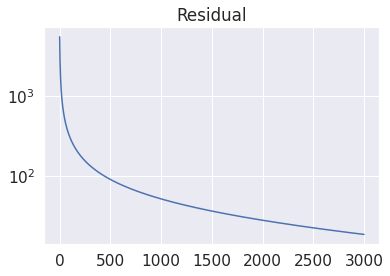

In [5]:
plt.semilogy(residual)
plt.title('Residual')

Сохраняем решение на диск

In [0]:
np.save('./history.npy',
        history
        )

In [0]:
history = np.load(
    './history.npy'
    )

Посмотрим, как решение выглядит в зависимости от времени:

In [0]:
def plot(index):
    plt.figure(figsize=(8, 8))
    sns.heatmap(history[index])
    plt.show()

In [9]:
interact(plot, index=(0, n_of_time_steps - 1))

interactive(children=(IntSlider(value=1499, description='index', max=2999), Output()), _dom_classes=('widget-i…

<function __main__.plot>

Здесь строим encoder. 

В данном случае сжимаем решение с помощью PCA (по сути - сингулярное разложение).

Главные векторы строим по небольшому куску истории. 

In [10]:
PCA_list = []
n_of_snapshots = 1500
start = 500
batch = 500
low_dim = 10
archived_history = np.zeros((n_of_snapshots, low_dim))

# for i in tqdm(range(0, n_of_snapshots, batch)):
#     new_pca = PCA(n_components=low_dim)
#     archived_history[i : i + batch] = \
#         new_pca.fit_transform(history[i:i + batch].reshape(-1, (N + 1) * (N + 1)))
#     PCA_list.append(new_pca)

my_pca = PCA(n_components = low_dim)

history_low_dim = np.zeros((batch, low_dim))

history_low_dim = my_pca.fit_transform(history[start:start + batch].reshape(-1, (N + 1) * (N + 1)))

 
def encode(X):
    # X : array-like, shape (n_samples, n_features)
    return my_pca.transform(X)

def decode(x):
    # x : array-like, shape (n_samples, n_components)
    return my_pca.inverse_transform(x)

print(history_low_dim[1, :])


[5.11871975e+00 3.61172178e-01 2.73010432e-02 2.10564012e-03
 1.62829946e-04 1.26075658e-05 9.89208388e-07 7.62890577e-08
 5.81009248e-09 4.38379660e-10]


TODO: Важно! Коэффициенты сильно отличаются по величине, так и должно быть, т.к. по сути это сингулярные числа, для проекции на сетку гладкого решения они убывают очень быстро.

Но для обучения это плохо: больший вклад в ошибку будут вносить только несколько первых компонент. Нужно подумать, нужна ли тут нормализация.

Проверим точность сжатия

In [11]:
X_ = history[start + batch : start + 2 * batch]
X = X_.reshape(batch, -1)
print('X.shape = ', X.shape)
x = encode(X)
print('x.shape = ', x.shape)

X_decode = decode(x)
error = np.linalg.norm(X[:] - X_decode[:])
print('error in fro-norm = {0:5.2e}'.format(error))

X.shape =  (500, 10201)
x.shape =  (500, 10)
error in fro-norm = 2.42e-04


Нарисуем график разных коэффициентов из маломерного вектора

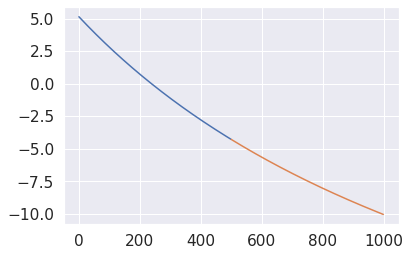

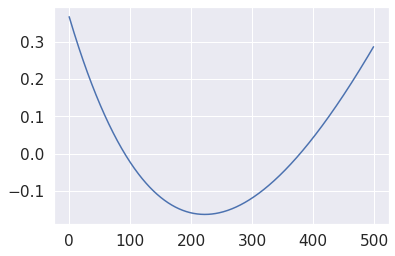

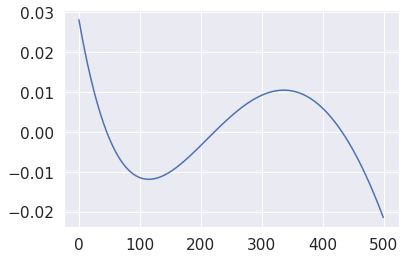

In [96]:
plt.plot(history_low_dim[:, 0], label = 'Component # 1')
plt.plot(np.arange(batch, 2 * batch), x[:, 0] )
plt.show()
plt.plot(history_low_dim[:, 1], label = 'Component # 2')
plt.show()

plt.plot(history_low_dim[:, 2], label = 'Component # 3')
plt.show()

С помощью PyTorch создаём простую модель LSTM

In [0]:
hidden_dim = 100

class SimpleModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.rnn = nn.LSTM(low_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, low_dim)

    def forward(self, seq, hidden=None):
        output, last_hidden = self.rnn(seq, hidden)
        return self.decoder(output), last_hidden


In [0]:
model = SimpleModel().double().cuda()

Задаём параметры обучения модели

In [0]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)



train = torch.from_numpy(history_low_dim).cuda()

In [16]:
train.shape

torch.Size([500, 10])

TODO: Добавить разбиение большой последовательности на много маленьких с заданным размером окна. 

Обучать на каждой из такой последовательностей предсказывать следующее значение. Кажется, что так аппроксимация будет более содержательная. В текущем виде, когда обучаем по всей последовательности предсказывать следующий, легче переобучиться.

In [0]:
# Разбиваем последовательность на пары вход-выход
def create_inout_sequences(input_data, in_size):
    '''
    input_data[i] - i-й элемент последовательности
    in_size - длина входной последовательности
    по in_size элементам мы будем предсказывать 
    следующий элемент
    '''
    inout_seq = []
    seq_len = len(input_data)
    for i in range(seq_len - in_size):
        train_seq = input_data[i : i + in_size]
        train_label = input_data[i + in_size : i + in_size + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

Начинаем обучение

In [70]:
model.train()
train_loss = []
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    output, last_hidden = model(train[:-1].view(-1, 1, 10))
    loss = loss_func(output.view(-1, 10), train[1:, :])
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    # model.eval()

    # output, _ = model(val[:-1].view(-1, 1, 10), last_hidden)

    # loss = loss_func(output.view(-1, 10), val[1:])
    # val_loss.append(loss.item())

Второй способ: разбиваем на подпоследовательности.

In [0]:
in_size = 100

train_inout_seq = create_inout_sequences(train, in_size)

In [0]:
# model.train()
# train_loss = []
# num_epochs = 1000
# for epoch in tqdm(range(num_epochs)):
#     for seq, label in train_inout_seq:
#       # Зануляем hidden_state
#       hidden_state = (torch.zeros(1, 1, hidden_dim),
#                         torch.zeros(1, 1, hidden_dim))
#       # Вычисляем 
#       output, last_hidden = model(train[:-1].view(-1, 1, 10))
#       loss = loss_func(output.view(-1, 10), train[1:, :])
#       train_loss.append(loss.item())
#       optimizer.zero_grad()

#       loss.backward()

#       optimizer.step()


#     # model.eval()

#     # output, _ = model(val[:-1].view(-1, 1, 10), last_hidden)

#     # loss = loss_func(output.view(-1, 10), val[1:])
#     # val_loss.append(loss.item())

Строим график, как убывает Loss

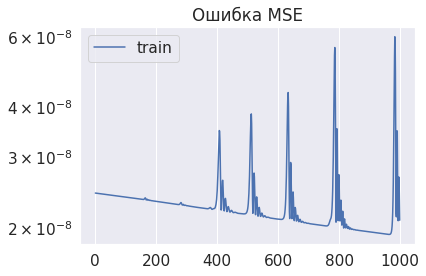

In [71]:
plt.semilogy(train_loss, label='train')
# plt.plot(val_loss, label='Val')
plt.title('Ошибка MSE')
plt.legend()
plt.show()

TODO: Добавить сравнение графиков для каждого из low_dim признаков: правильное значение, и то что предсказывает LSTM. 
Это покажет, насколько хорошо мы обучились

In [107]:
model.eval()

seq_len = 200

predicted = np.zeros((batch - seq_len, low_dim))

for i in range(batch - seq_len):
    output, last_hidden = model(train[i : i + seq_len].view(-1, 1, 10))
    
    predicted[i, :] = output[-1, :, :].cpu().detach().numpy()
output.shape

torch.Size([200, 1, 10])

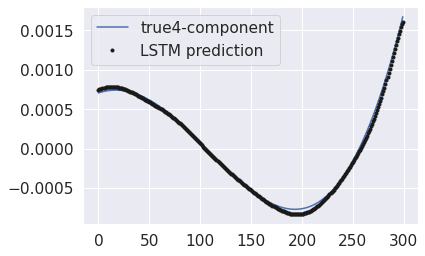

In [109]:
i = 3 # number of component
plt.plot(history_low_dim[seq_len:, i], label = 'true' +  str(i+1) + '-component')
plt.plot(predicted[:, i], 'k.', label = 'LSTM prediction')

plt.legend()
plt.show()

Теперь вычисляем малоразмерные представления на следующих итерациях, декодируем их в полное решение, и смотрим, как меняется невязка для этих решений

In [0]:
# last_hidden = (torch.zeros(1, 1, hidden_dim),
#                         torch.zeros(1, 1, hidden_dim))

In [88]:
model.eval()
import copy
seq_len = 100
sequence = torch.from_numpy(history_low_dim).cuda()
print(sequence.shape)
# output, last_hidden = model(sequence[-batch:].view(-1, 1, 10))
# TODO: как использовать hidden_state с предыдущих шагов?
for i in tqdm(range(batch)):
    # Предсказываем следующий элемент последовательности и hidden_state 
    output, last_hidden = model(sequence[-seq_len:].view(-1, 1, 10))
    # Добавляем новый элемент в конец
    sequence = torch.cat((sequence, output[-1]))
print(output.shape)

torch.Size([500, 10])



torch.Size([100, 1, 10])


In [89]:
print(type(last_hidden))
print(len(last_hidden))
print(type(last_hidden[0]))
print(last_hidden[0].shape)

<class 'tuple'>
2
<class 'torch.Tensor'>
torch.Size([1, 1, 100])


In [90]:
residual_lstm = []
sequence_numpy = sequence.data.cpu().numpy()

u = decode(sequence_numpy[:, :])
u = u.reshape((-1, N+1, N+1))

for i in tqdm(range(len(u))):
    res = compute_residual(u[i, :, :], h, tau)
    residual_lstm.append(res)

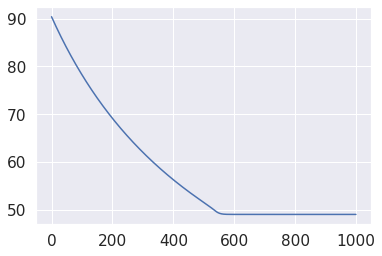

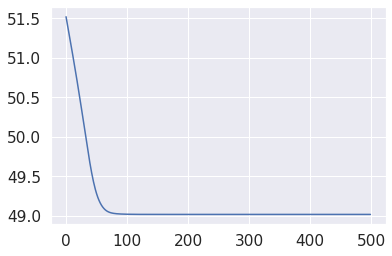

In [91]:
plt.plot(residual_lstm)
plt.show()
plt.plot(residual_lstm[batch:])

In [0]:
du = u[1:, :, :] - u[:-1, :, :]

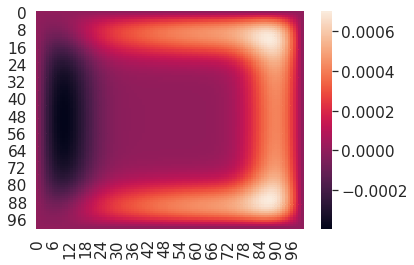

In [105]:
sns.heatmap(du[1, :, :])

График невязки

In [0]:
# val_results = output.view(-1, 10).cpu().detach().numpy()
# reshaped_results = np.zeros((5000, (N + 1) * (N + 1)))

# new_output = val[0].view(-1, 1, 10)
# new_hidden = last_hidden

# for i in range(5000):
#     new_output, new_hidden = model(new_output, new_hidden)
#     reshaped_results[i] = \
#         PCA_list[(1500 + i) // 500].inverse_transform(
#             new_output.cpu().detach().numpy().reshape(1, -1)
#             )[0]


# reshaped_results = reshaped_results.reshape(-1, N + 1, N + 1)  

In [0]:
def plot(index):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title('Предсказание LSTM')
    sns.heatmap(reshaped_results[index])
    tol = np.max(np.abs(reshaped_results[index] - reshaped_results[index + 1]))/\
            np.max(np.abs(reshaped_results[index + 1]))
    print('Текущая невязка LSTM: ', tol)

    plt.subplot(1, 2, 2)
    plt.title('Истинная функция')
    sns.heatmap(history[1500 + index])
    plt.show()

In [0]:
for i in range(0, 4999, 100):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title(f'Предсказание LSTM {i}')
    sns.heatmap(reshaped_results[i])

    plt.subplot(1, 2, 2)
    plt.title(f'Истинная функция {i}')
    sns.heatmap(history[1500 + i])
    plt.savefig(
        f'./step_{i}'
        )
    plt.close()

Невязка LSTM:

In [0]:
tol_list = []

for index in range(4999):
    tol_list.append(
        compute_residual(reshaped_results[index + 1],  h, tau)
    )

In [0]:
plt.figure(figsize=(8,8))
plt.semilogy(np.arange(1500, 6500 - 1), tol_list)
plt.title('Невязка')
plt.xlabel('Итерация метода')
plt.show()

In [0]:
residual.shape

Модельная задача. Проверим, что мы правильно используем LSTM.

In [0]:
# Создадим простой временной ряд - значения функции от t
f = lambda t : np.sin(t) * t

t = np.linspace(0, 20, 100)

fval = f(t)

plt.plot(fval)

In [0]:
f_train = fval[0:40]
f_val =   fval[40:60]
f_test =  fval[60:]

In [0]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, seq):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        # c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        out, hidden = self.lstm(seq, h_t)
        target = self.linear(out)
        
        return target


In [0]:
hidden_state = 100

class MyLSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.target_size = target_size

        self.rnn = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim)
        self.decoder = nn.Linear(hidden_dim, target_size)

    def forward(self, seq, hidden=None):
        output, last_hidden = self.rnn(seq, hidden)
        return self.decoder(output), last_hidden

Потестируем отдельные слои torch, чтобы понять где какие размерности тензоров

In [0]:
temp_lstm = nn.LSTM(input_size = 1, hidden_size = 10)
temp_lin =  nn.Linear(10, 1)

seq = torch.FloatTensor([1,2,3,4])

output, (h_n, c_n) = temp_lstm(seq.view(4, 1, 1))

target = temp_lin(output)

print("target.shape = ", target.shape)
# print(target)

print( "output.shape = ",  output.shape)
print("h_n.shape = ", h_n.shape)
print("c_n.shape = ", c_n.shape)

In [0]:
my_lstm = MyLSTM(1, 20, 1)
seq = torch.FloatTensor([1., 2., 3.])
result, last_hidden = my_lstm.forward(seq)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    output, last_hidden = model(train[:-1].view(-1, 1, 10))
    loss = loss_func(output.view(-1, 10), train[1:, :])
    train_loss.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()

    output, _ = model(val[:-1].view(-1, 1, 10), last_hidden)

    loss = loss_func(output.view(-1, 10), val[1:])
    val_loss.append(loss.item())

In [0]:
a = np.array([1,2,3,4])

b = np.reshape(a, (4,1))
print(b)